In [15]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split


In [16]:
df = pd.read_csv('../data/Auto_MPG.csv')
df.dropna(inplace=True)

In [17]:
X = df.drop(columns='MPG')
y = df.MPG

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2)


In [18]:
X_train_tf = tf.convert_to_tensor(X_train, dtype=tf.float32)
X_test_tf = tf.convert_to_tensor(X_test, dtype=tf.float32)

y_train_tf = tf.convert_to_tensor(y_train, dtype=tf.float32)
y_test_tf = tf.convert_to_tensor(y_test, dtype=tf.float32)


In [19]:
def one_hot_origin(X):
    origin = tf.cast(X[:, -1], dtype=tf.int32)
    origin_oh = tf.one_hot(origin - 1, 3)
    return tf.concat([X[:, :-1], origin_oh], axis=1)


In [20]:
X_train_tf_ohe = one_hot_origin(X_train_tf)
X_test_tf_ohe = one_hot_origin(X_test_tf)

In [21]:
class Normalize(tf.Module):
    def __init__(self, x):
        self.mean = tf.math.reduce_mean(x, axis=0)
        self.std = tf.math.reduce_std(x, axis=0)

    def norm(self, x):
        return (x - self.mean) / self.std

    def unnorm(self, x):
        return (x * self.std) + self.mean


In [22]:
norm_X = Normalize(X_train_tf_ohe)
norm_y = Normalize(y_train_tf)

X_train_tf_norm = norm_X.norm(X_train_tf_ohe)
X_test_tf_norm = norm_X.norm(X_test_tf_ohe)

y_train_tf_norm = norm_y.norm(y_train_tf)
y_test_tf_norm = norm_y.norm(y_test_tf)


In [23]:
class LinearRegression(tf.Module):
    def __init__(self):
        self.built = False

    @tf.function
    def __call__(self, x):
        if not self.built:
            rand_w = tf.random.uniform(shape=[x.shape[1], 1])
            rand_b = tf.random.uniform(shape=[])

            self.w = tf.Variable(rand_w)
            self.b = tf.Variable(rand_b)
            self.built = True

        y = tf.add(tf.matmul(x, self.w), self.b)
        return tf.squeeze(y)

def mse_loss(y_preds, y):
    return tf.math.reduce_mean(tf.square(y_preds - y))


In [24]:
batch_size = 64

train_dataset = tf.data.Dataset.from_tensor_slices((X_train_tf_norm, y_train_tf_norm))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test_tf_norm, y_test_tf_norm))

train_dataset = train_dataset.shuffle(buffer_size=X_train_tf_norm.shape[0], reshuffle_each_iteration=True).batch(batch_size=batch_size)
test_dataset = test_dataset.shuffle(buffer_size=X_test_tf_norm.shape[0], reshuffle_each_iteration=True).batch(batch_size=batch_size)


In [25]:
epochs = 100
learning_rate = 0.01
train_losses, test_losses = [], []

lin = LinearRegression()

for epoch in range(epochs):
    batch_losses_train, batch_losses_test = [], []

    for X_train, y_train in train_dataset:
        with tf.GradientTape() as tape:
            y_pred_batch = lin(X_train)
            batch_loss = mse_loss(y_pred_batch, y_train)

        grads = tape.gradient(batch_loss, lin.variables)
        for g, v in zip(grads, lin.variables):
            v.assign_sub(learning_rate * g)

        batch_losses_train.append(batch_loss)

    train_loss = tf.math.reduce_mean(batch_losses_train)
    train_losses.append(train_loss)

    for X_test, y_test in test_dataset:
        y_pred_batch = lin(X_test)
        batch_loss = mse_loss(y_pred_batch, y_test)

        batch_losses_test.append(batch_loss)

    test_loss = tf.math.reduce_mean(batch_losses_test)
    test_losses.append(test_loss)

    if epoch % 10 == 0:
        print('Train MSE Loss for', epoch, train_loss)
        print('Test MSE Loss for', epoch, test_loss)


Train MSE Loss for 0 tf.Tensor(3.4275498, shape=(), dtype=float32)
Test MSE Loss for 0 tf.Tensor(2.04565, shape=(), dtype=float32)
Train MSE Loss for 10 tf.Tensor(0.37663302, shape=(), dtype=float32)
Test MSE Loss for 10 tf.Tensor(0.5153346, shape=(), dtype=float32)
Train MSE Loss for 20 tf.Tensor(0.24365158, shape=(), dtype=float32)
Test MSE Loss for 20 tf.Tensor(0.31066555, shape=(), dtype=float32)
Train MSE Loss for 30 tf.Tensor(0.21178408, shape=(), dtype=float32)
Test MSE Loss for 30 tf.Tensor(0.27433997, shape=(), dtype=float32)
Train MSE Loss for 40 tf.Tensor(0.20054951, shape=(), dtype=float32)
Test MSE Loss for 40 tf.Tensor(0.31167454, shape=(), dtype=float32)
Train MSE Loss for 50 tf.Tensor(0.1956386, shape=(), dtype=float32)
Test MSE Loss for 50 tf.Tensor(0.28479347, shape=(), dtype=float32)
Train MSE Loss for 60 tf.Tensor(0.19269426, shape=(), dtype=float32)
Test MSE Loss for 60 tf.Tensor(0.206886, shape=(), dtype=float32)
Train MSE Loss for 70 tf.Tensor(0.19022003, shape=(

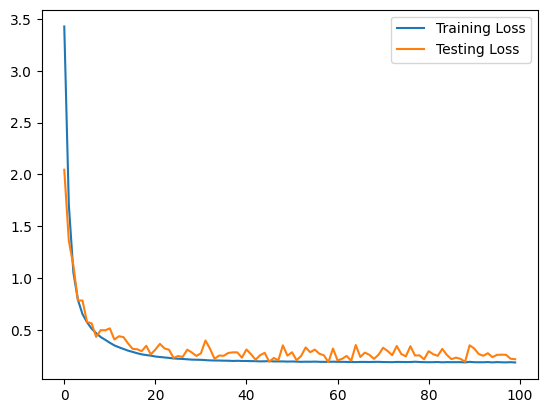

In [26]:
import matplotlib.pyplot as plt

plt.plot(range(epochs), train_losses, label='Training Loss')
plt.plot(range(epochs), test_losses, label='Testing Loss')
plt.legend()

In [27]:
class ExportModule(tf.Module):
    def __init__(self, model, extract_features, norm_x, norm_y):
        self.model = model
        self.extract_features = extract_features
        self.norm_x = norm_x
        self.norm_y = norm_y

    def __call__(self, x):
        x = self.extract_features(x)
        x = self.norm_x.norm(x)
        y = self.model(x)
        y = self.norm_y.unnorm(y)

        return y

In [28]:
lin_export = ExportModule(lin, extract_features=one_hot_origin, norm_x=norm_X, norm_y=norm_y)
print(lin_export(X_test_tf)[15:20])
print(y_test_tf[15:20])

tf.Tensor([24.971668  8.699001 23.500982 19.54038  34.23899 ], shape=(5,), dtype=float32)
tf.Tensor([23.8 10.  19.1 19.4 34.1], shape=(5,), dtype=float32)
